In [26]:
import torch
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
import copy
import sys
from scipy import ndimage
cmap=plt.cm.Spectral_r
from mpl_toolkits import mplot3d
from pathlib import Path

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
font = {'family' : 'serif', 'size':12}
plt.rc('font', **font)
plt.rc("lines", linewidth=3.0)
plt.rcParams["savefig.dpi"] = 500
cmap = plt.get_cmap('Spectral_r')

In [27]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

def h2p(width, input_size, depth):
    return input_size*width + (depth-1) * width**2 + width
h2p = np.vectorize(h2p)

In [30]:
#1588503259 Tanh random 13
#1589233778 ReLU random 15
#1589269331 ReLU MNIST

paths = sorted(glob.glob('r.*'), key=os.path.getmtime)
last = paths[-1]
path = last
#path = 'r.1588503259'
path+='/'
print(path)

runs = []
params = torch.load(path+'params.pkl')
files = glob.glob(path + '*.pyT')
for ifile, file in enumerate(files):
    if ifile%(len(files)//10)==0:
        print(ifile, len(files))
    runs.append(torch.load(file))
args = runs[0]['args']

print(runs[0]['args'],'\n')
for k, v in params.items():
    print(k,v)

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if getattr(run['args'],k) != v:
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

max_width=12

savedir= './figs/{activation[0]}_{dataset[0]}/'.format(**params)
if not os.path.exists(savedir):
    os.mkdir(savedir)
print(savedir)

r.1592914021/
0 843
84 843
168 843
252 843
336 843
420 843
504 843
588 843
672 843
756 843
840 843
Namespace(activation='tanh', bs=1000000, d=196, dataset='MNIST', depth=2, epochs=1000, loss_type='mse', lr=0.001, mom=0.0, n=1, n_classes=1, n_test=10000, name='r.1592914021/000001', no_cuda=False, noise=0.5, num_seeds=10, task='regression', teacher_depth=2, teacher_width=100, test_noise=False, wd=0, width=1) 

width [   1    2    4    6    8   12   18   26   37   54   78  112  162  233
  335  483  695 1000]
n [     1      1      3      6     11     20     37     69    127    233
    428    784   1438   2636   4832   8858  16237  29763  54555 100000]
depth [2]
wd [0]
activation ['tanh']
dataset ['MNIST']
noise [0, 0.5, 5]
lr [0.001]
mom [0.0]
d [196]
num_seeds [10]
test_noise [False]
loss_type ['mse']
epochs [1000]
no_cuda [False]
teacher_depth [2]
teacher_width [100]
n_test [10000]
bs [1000000]
n_classes [1]
task ['regression']
./figs/tanh_MNIST/


# Analysis

[[2.37679271e+00 3.13387249e+00 3.81632450e+00 3.44388449e+00
  2.97420454e+00 2.73082862e+00 2.21992668e+00 1.84098713e+00
  1.65847903e+00 1.46139417e+00 1.39118713e+00 1.41224289e+00]
 [7.01435575e+00 1.18223650e+01 1.90658493e+01 2.13656763e+01
  2.17437828e+01 2.15279011e+01 2.03890676e+01 1.96688574e+01
  1.78808327e+01 1.47182526e+01 1.34720937e+01 1.17547060e+01]
 [5.16415324e+00 8.59043736e+00 1.28123507e+01 1.38913640e+01
  1.48875889e+01 1.55935400e+01 1.53462627e+01 1.57884043e+01
  1.54579321e+01 1.39602291e+01 1.31912888e+01 1.21943748e+01]
 [6.50666869e+00 1.15467917e+01 1.57083145e+01 1.63766957e+01
  1.60406719e+01 1.65139113e+01 1.57324895e+01 1.50575334e+01
  1.38224092e+01 1.29373652e+01 1.24220358e+01 1.16829464e+01]
 [5.69817225e+00 1.10942544e+01 1.81024492e+01 2.05362938e+01
  2.23118206e+01 2.28574770e+01 2.41234221e+01 2.41365484e+01
  2.26525555e+01 2.17041073e+01 1.96106821e+01 1.83631771e+01]
 [3.78202122e+00 7.98823254e+00 1.43350223e+01 1.73669374e+01
  2

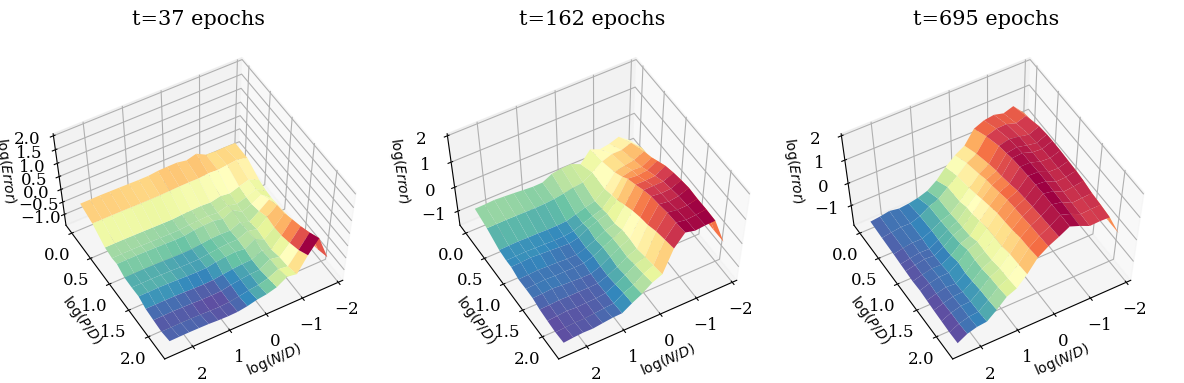

In [45]:
def plot_phase_space(original_runs, original_params, constraints, ensembling=False, dynamics=False, save=False):
    runs, params = select_runs(original_runs, original_params, constraints)

    if dynamics:
        original_steps = runs[0]['checkpoints']
        if ensembling:
            raise('No dynamics for ensembling')
        steps = runs[0]['checkpoints'][8::4]
    else:
        steps = [-1]

    fig = plt.figure(figsize=(4*len(steps),4))
    grid = {'train_loss':np.zeros((len(steps),len(params['n']),len(params['width']))),
           'test_loss':np.zeros((  len(steps),len(params['n']),len(params['width']))),
           'test_error':np.zeros(( len(steps),len(params['n']),len(params['width'])))}

    for run in runs:
        args = run['args']
        i, j = find(params['n'],args.n), find(params['width'],args.width)

        for it,t in enumerate(steps):
            if ensembling:
                test_loss =   run['te_loss_ens']
                test_error = 1-run['te_acc_ens']
            else:
                true_it = find(original_steps,t) if dynamics else -1
                train_loss =  run['tr_loss'][true_it]
                test_loss =   run['te_loss'][true_it]
                test_error = 1-run['te_acc'][true_it]
            #if np.isnan(test_loss): print(i,j)
            grid['test_loss'] [it,i,j] = test_loss
            #grid['train_loss'][it,i,j] = train_loss
            grid['test_error'][it,i,j] = test_error

    for k in grid:
        grid[k]=grid[k][:,2:-1,:max_width]
    params['p'] = h2p(params['width'], args.d, args.depth)        
    x, y = np.meshgrid(params['n'][2:-1], params['p'][:max_width])
    print(grid['test_loss'][it])

    from itertools import product
    for it in range(len(steps)):
        ax = fig.add_subplot(1,len(steps), it+1,projection='3d')
        ax.plot_surface(np.log10(x/params['d']), np.log10(y/params['d']), np.log10(grid['test_loss'][it].T), cmap=cmap)
        ax.view_init(60, 60)
        ax.set_xlabel(r'$\log(N/D)$',     fontsize=10)
        ax.set_ylabel(r'$\log(P/D)$',     fontsize=10)
        ax.set_zlabel(r'$\log(Error)$',   fontsize=10)
        #if dynamics: ax.set_zlim(top=np.log10(np.max(grid['test_loss'])))
        if constraints['noise']==max(original_params['noise']): ax.set_zlim(top=2)
        if dynamics: ax.set_title('t={0:.0f} epochs'.format(steps[it]), pad=40, fontsize=15)

    plt.tight_layout()
    if save:
        savename = '{}_{}/ens_{}_depth_{}_wd_{}_noise_{}.pdf'.format(ensembling, constraints['activation'], constraints['dataset'],
                                                                 constraints['depth'], constraints['wd'], constraints['noise'])
        if dynamics: savename = 'dynamics_'+savename
        plt.savefig(savedir+savename)
    plt.show()
    
        
constraints = {}
constraints['wd'] = 0.0
constraints['noise'] = 5
constraints['depth'] = 2

plot_phase_space(runs, params, constraints, ensembling=False, dynamics=True)

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


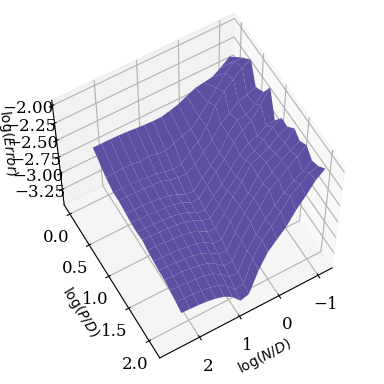

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


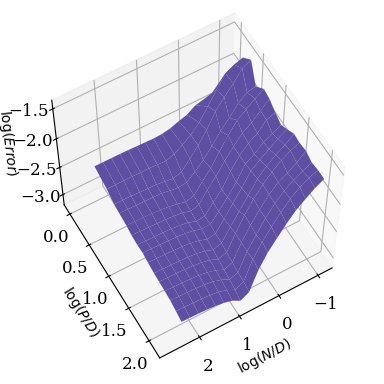

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


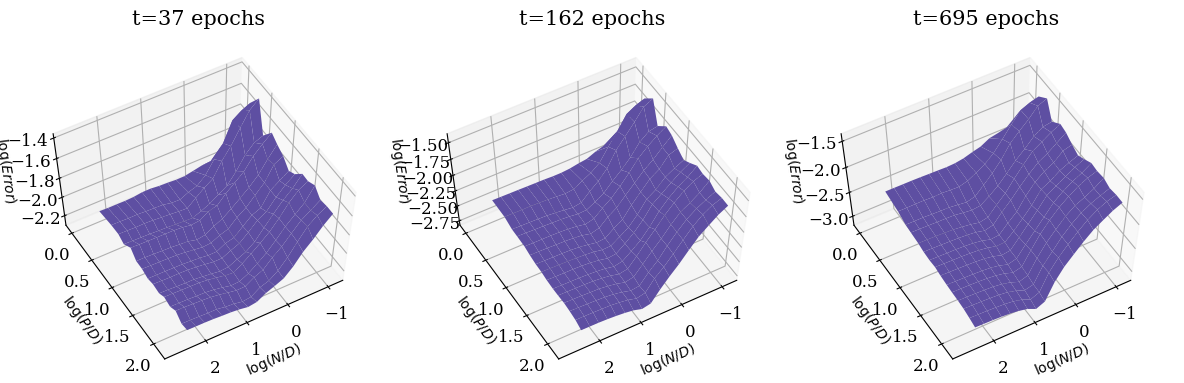

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


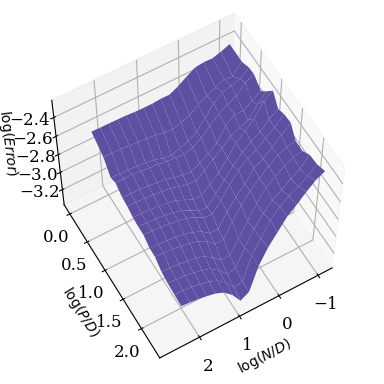

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


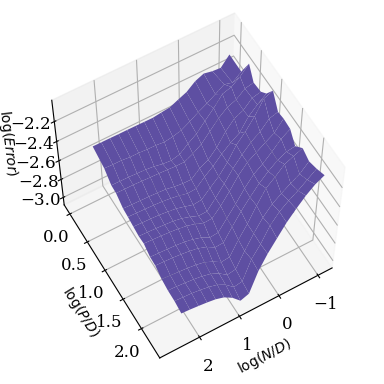

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


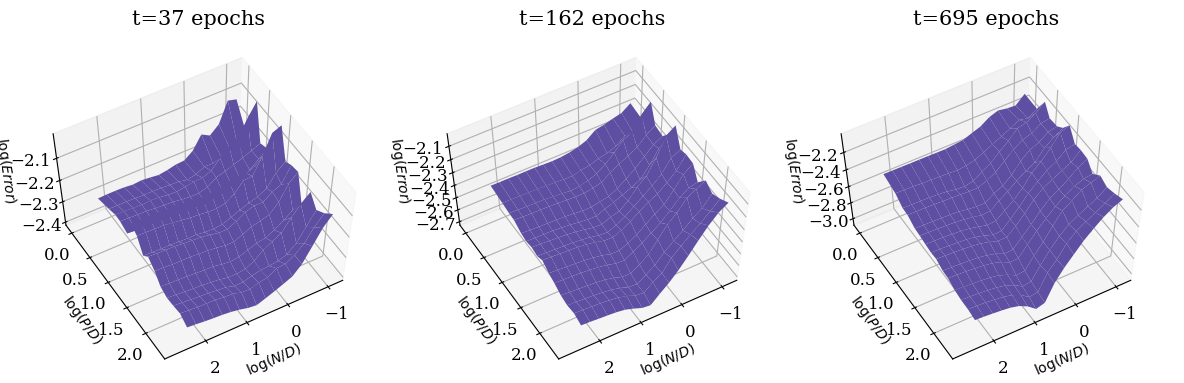

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


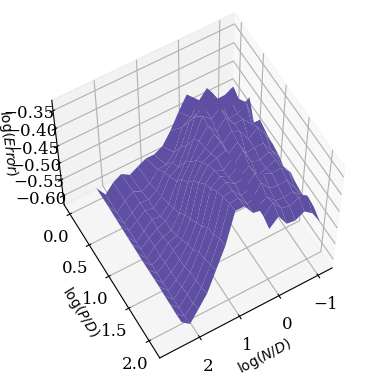

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


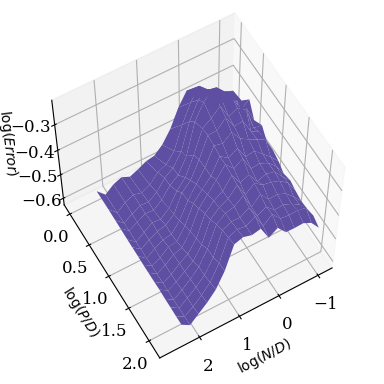

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


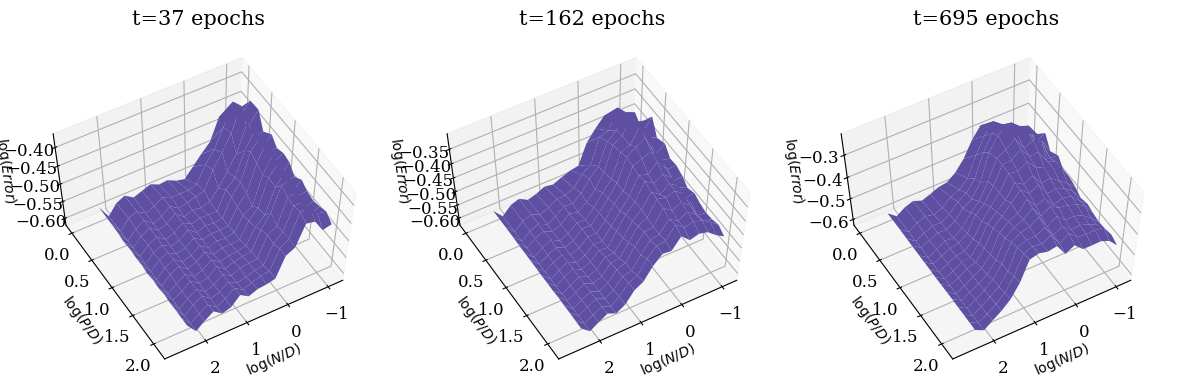

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


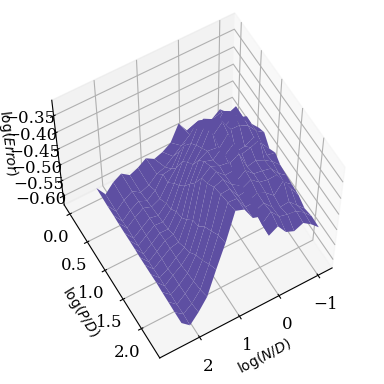

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


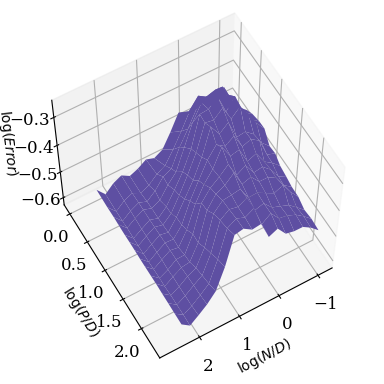

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


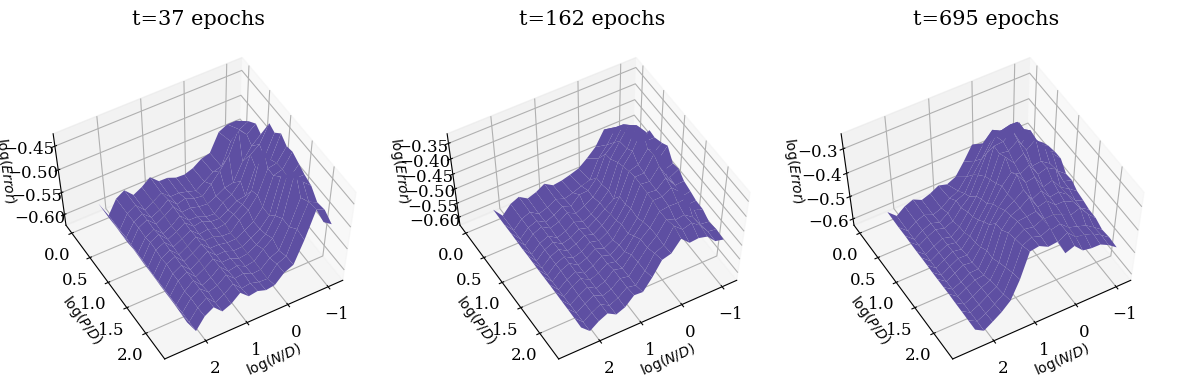

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


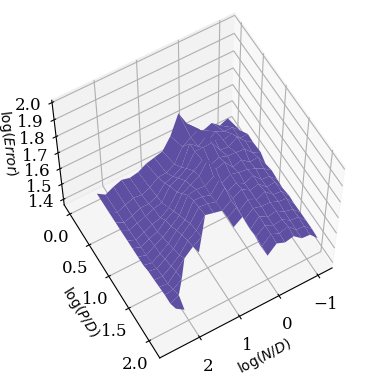

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


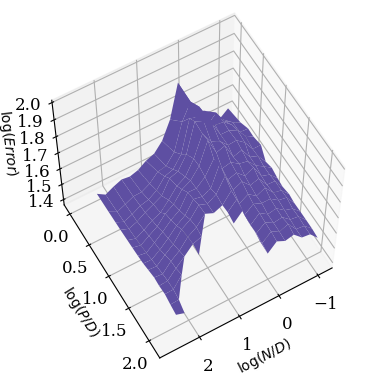

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


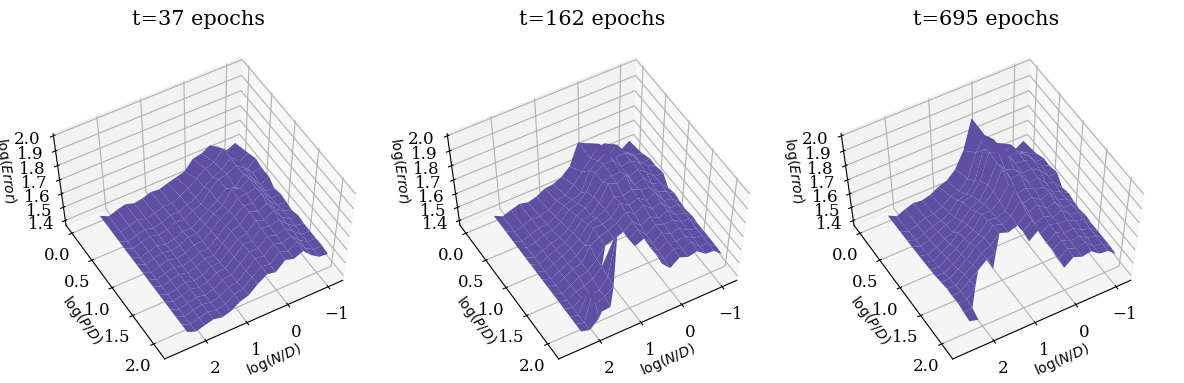

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


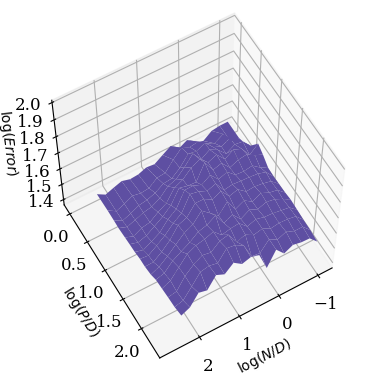

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


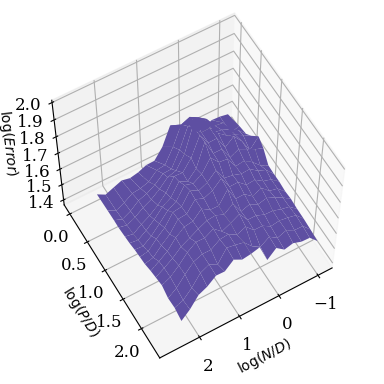

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


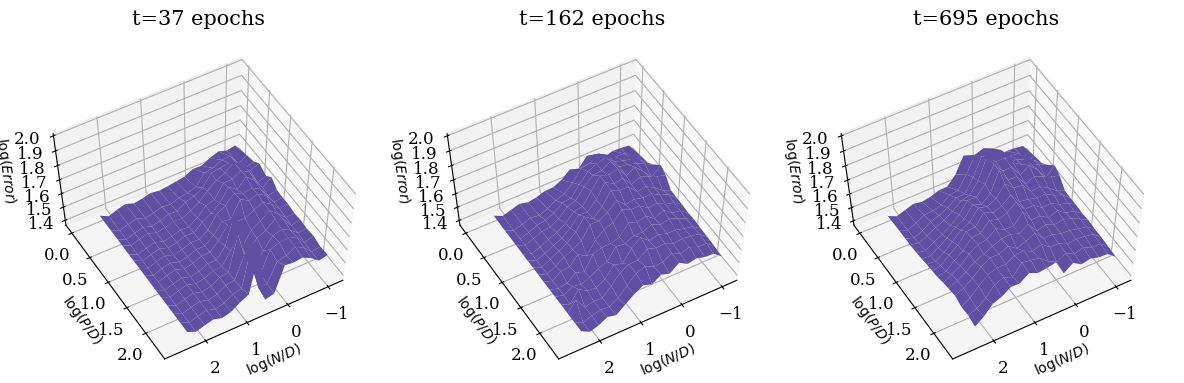

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


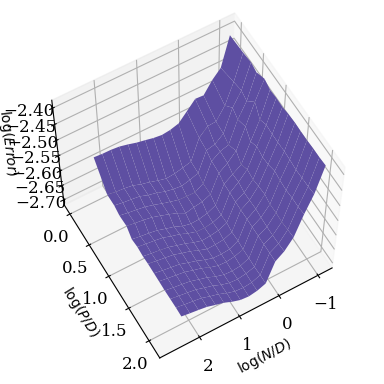

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


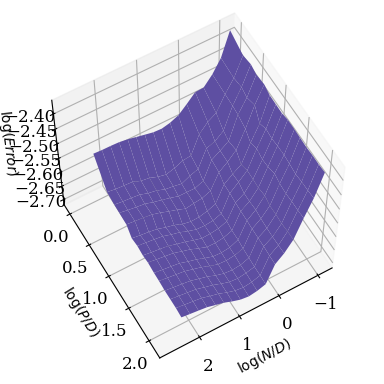

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


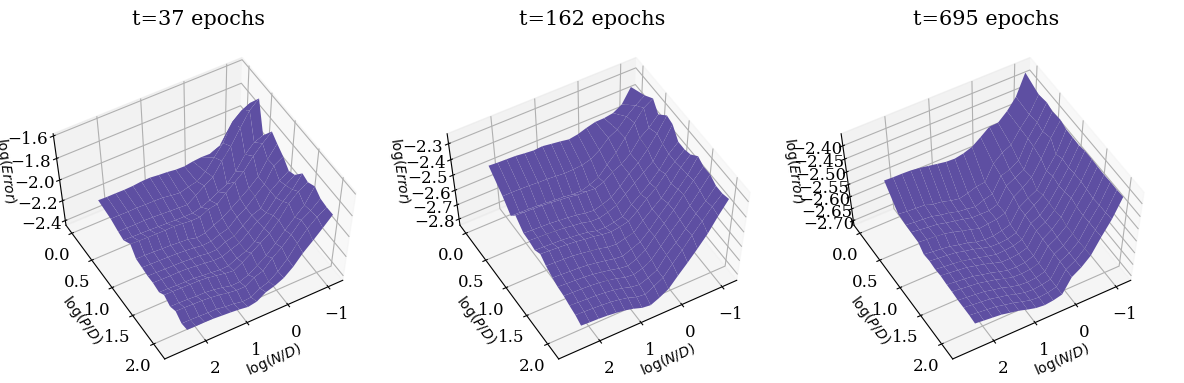

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


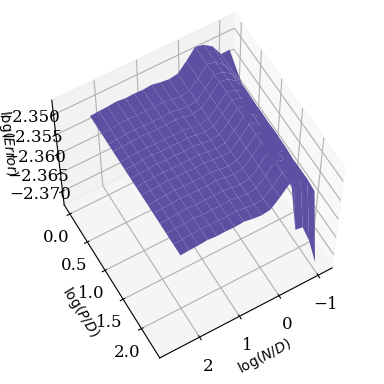

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


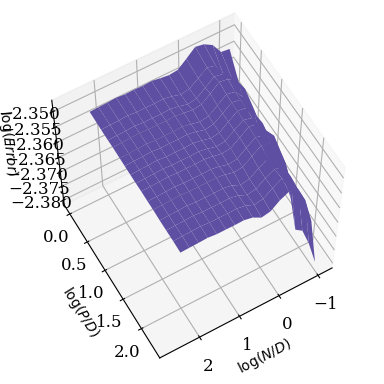

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


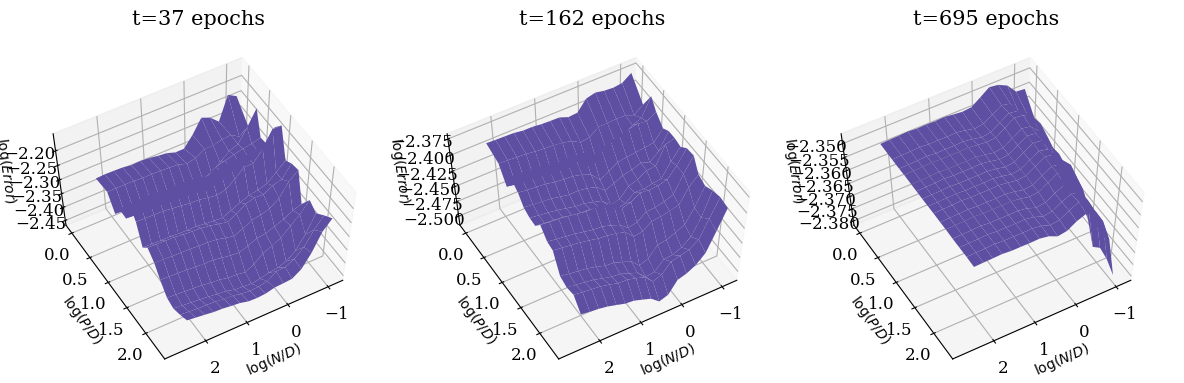

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


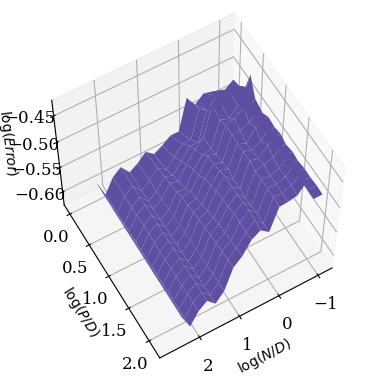

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


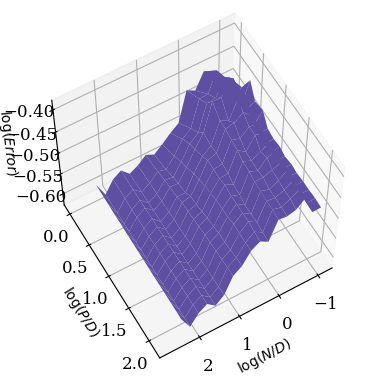

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


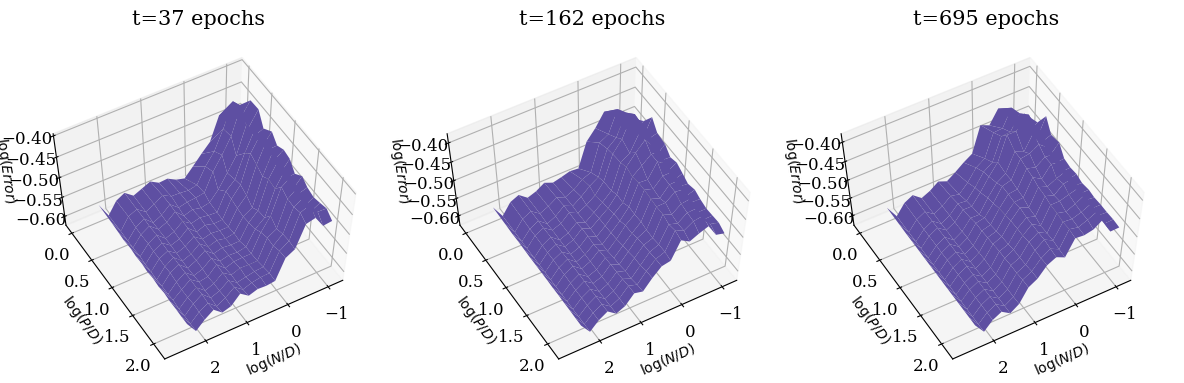

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


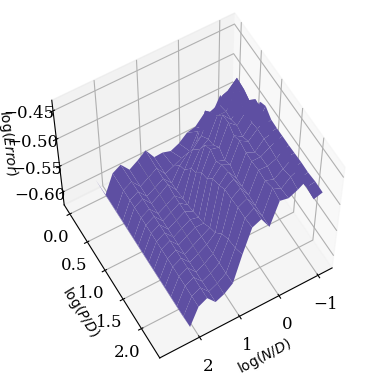

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


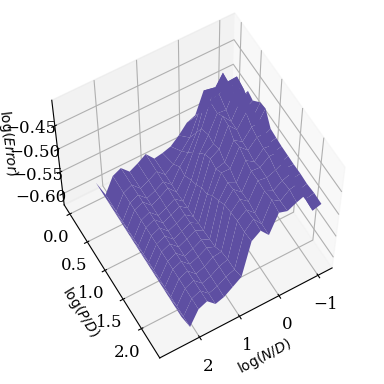

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


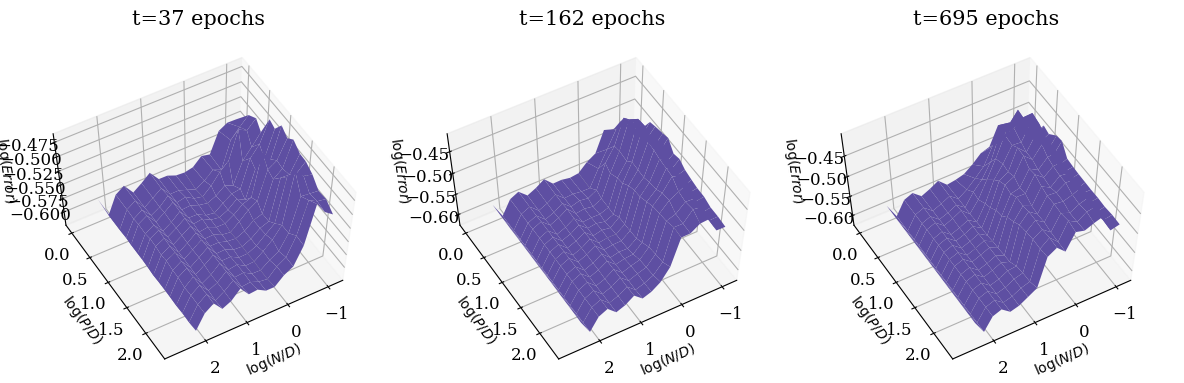

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


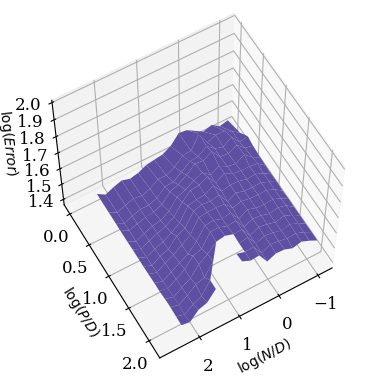

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


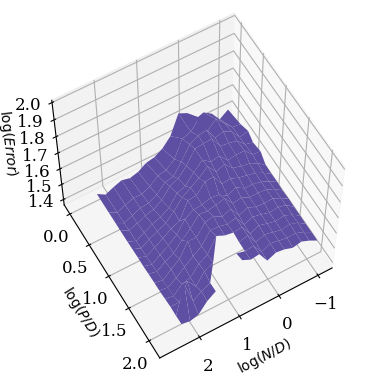

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


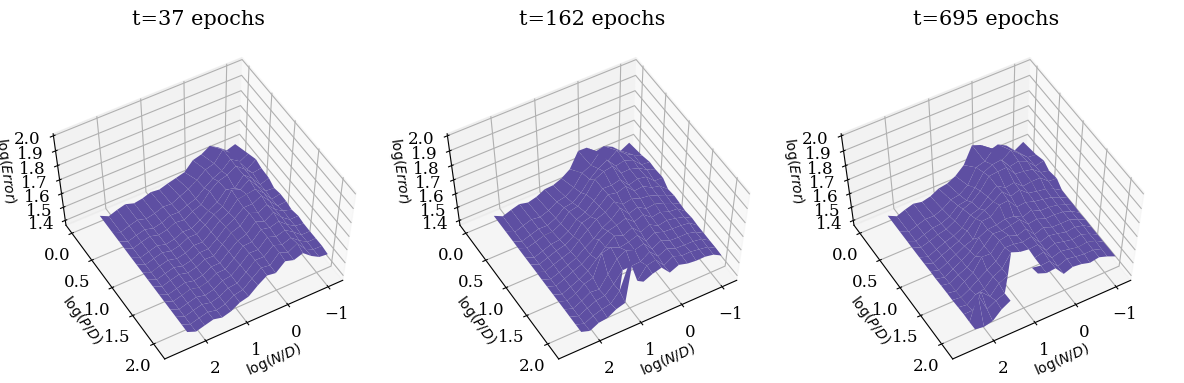

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


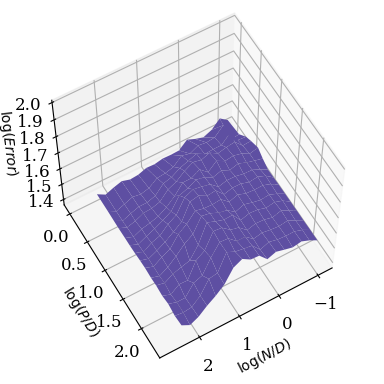

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


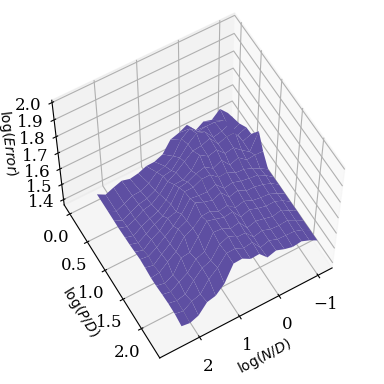

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


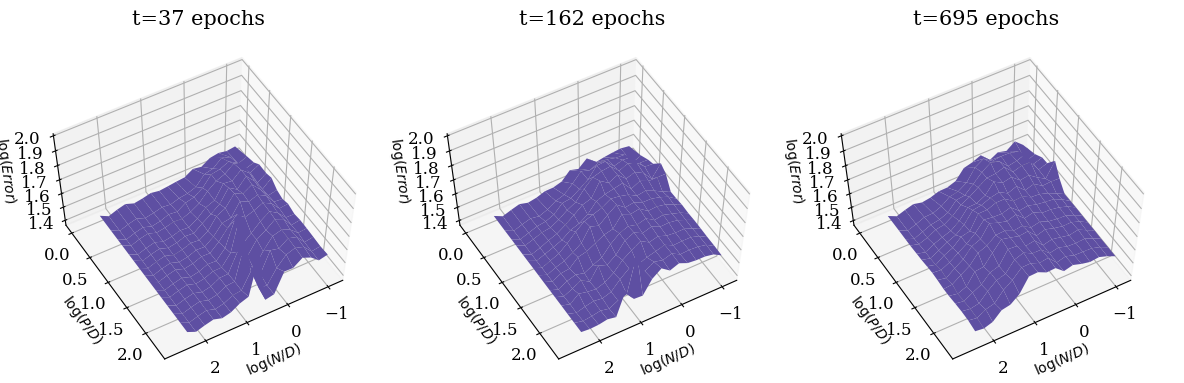

In [24]:
save=True
for dataset in params['dataset']:
    for activation in params['activation']:
    for wd in params['wd']:
        for noise in params['noise']:
            for depth in params['depth']:
                for ensembling in [True,False]:
                    constraints={'wd':wd,'noise':noise,'depth':depth}
                    plot_phase_space(runs, params, constraints, ensembling=ensembling, dynamics=False, save=save)
                    if not ensembling:
                        plot_phase_space(runs, params, constraints, ensembling=ensembling, dynamics=True, save=save)

# Varying two params

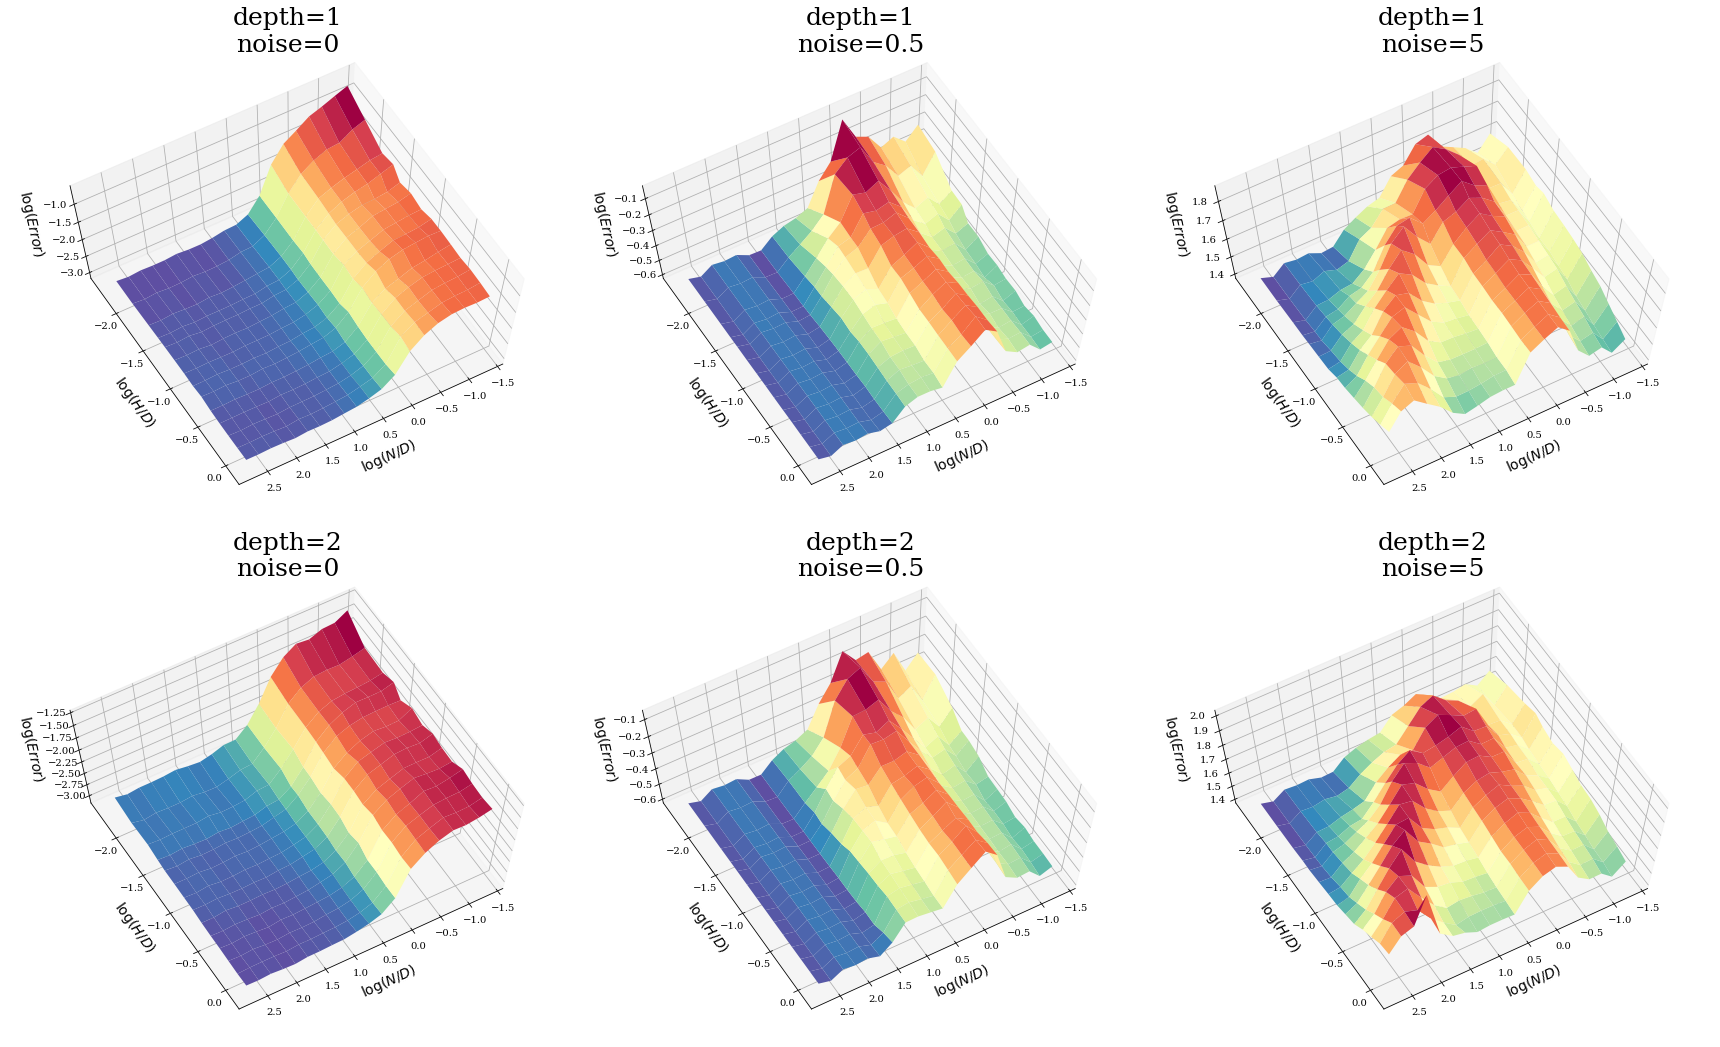

In [10]:
constraints = {}
constraints['wd'] = 0.0
runs, params = select_runs(runs, params, constraints)

var1='depth' #'noise'
var2='noise' #'noise'
ensembling=False
fig = plt.figure(figsize=(8*len(params[var2]),8*len(params[var1])))

grid = {'train_loss':np.zeros((len(params[var1]),len(params[var2]),len(params['n']),len(params['width']))),
       'test_loss':np.zeros((  len(params[var1]),len(params[var2]),len(params['n']),len(params['width']))),
       'test_error':np.zeros(( len(params[var1]),len(params[var2]),len(params['n']),len(params['width'])))}

for run in runs:
    args = run['args']
    i, j, k, l = find(params[var1],getattr(args,var1)), find(params[var2], getattr(args,var2)), find(params['n'],args.n), find(params['width'],args.width)
    
    train_loss =  run['tr_loss'][-1]
    if ensembling:
        test_loss =   run['te_loss_ens']
        test_error = 1-run['te_acc_ens']
    else:
        test_loss =   run['te_loss'][-1]
        test_error = 1-run['te_acc'][-1]
    
    grid['test_loss'] [i,j,k,l] = test_loss
    grid['train_loss'][i,j,k,l] = train_loss
    grid['test_error'][i,j,k,l] = test_error

for k in grid:
    grid[k]=grid[k][:,:,:,:max_width]
x, y = np.meshgrid(params['n'][:], params['width'][:max_width])

from itertools import product
for counter, (i,j) in enumerate(product(range(len(params[var1])),range(len(params[var2])))):
        ax = fig.add_subplot(len(params[var1]),len(params[var2]), counter+1,projection='3d')
        ax.plot_surface(np.log10(x/params['d']), np.log10(y/params['d']), np.log10(grid['test_loss'][i,j].T), cmap=cmap)
        ax.view_init(70, 60)
        #ax.set_title('{}={}, {}={}'.format(var1, params[var1][i], var2, params[var2][j]))
        ax.set_xlabel(r'$\log(N/D)$',     fontsize=14, labelpad=10)
        ax.set_ylabel(r'$\log(H/D)$',     fontsize=14, labelpad=10)
        ax.set_zlabel(r'$\log(Error)$',   fontsize=14, labelpad=10)
        #ax.set_zlim(top=2)
        ax.set_title('{}={}\n{}={}'.format(var1,params[var1][i], var2,params[var2][j]), pad=40, fontsize=25)
        #ax.set_zlim(0, 0.4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig(savedir+'triple_descent_dnn.pdf')